In [1]:
import matplotlib.pyplot as plt
import numpy
import os# this environment variable points to the 'settings' module 
# in the Django app.
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "server.settings.dev_settings")# maybe not be necessary if you hard coded you DB URL in settings, 
# but mine it pulled from the DATABASE_URL environment variable
os.environ.setdefault("DATABASE_URL", 
"postgres://localhost:5432/db")# and then...
import django
django.setup()

In [2]:
from django.shortcuts import render
from users.models import Patient

# Create your views here.

from datetime import date

# PROTEIN_RATIO = 0.8 # the number based on the weights
PROTEIN_RATIO = 0.2
LIPID_RATIO = 0.3 # OR LIPID_RATIO = 0.35
CARB_RATIO = 0.5

# Solution to calcuate age, 
# source: Danny W. Adair,  https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Get patient  by the user
def get_patient_by_user_id(user_id):
    patient = Patient.objects.get(pk=user_id)
    return patient

def get_patient_info(user_id):
    patient = get_patient_by_user_id(user_id)    
    age = calculate_age(patient.birth_date)
    height = patient.height / 100
    weight = patient.weight
    activity_level = patient.activity.score # PA
    print("patient_name:", patient)    
    print("age: " + str(age))
    print("height: " + str(height))
    print("weight: " + str(weight))
    print("activity level: " + str(activity_level))
    '''
    # Estimated Energy Requirement (kcal/day) = Total Energy Expenditure
    #EER = 354 − (6.91 × age [y]) + PA × [(9.36 × weight [kg]) + (726 v height [m])]
    # compared correctly with https://fnic.nal.usda.gov/fnic/dri-calculator/results.php 
    '''
    energy = 354 - (6.91 * age) + activity_level * ( (9.36 * weight) + (726 * height) ) 
    print("EER: " + str(energy))
    ''' calculate nutritional needs '''
    # protein =  PROTEIN_RATIO*weight
    
    ''' carbohydrates should be around 45->65%  '''
    carbohydrate = CARB_RATIO*energy/4

    lipid = LIPID_RATIO*energy/9
    
    protein = (PROTEIN_RATIO*energy)/4
    
#     print("carb: "+str(carbohydrate))    
#     print("protein: " + str(protein))
#     print("lipid: " + str(lipid))
#     print('you needs:')
    #energy = P*4 + L*9 + C*4
    print("carbs: " + str(carbohydrate) + ". Accounts for " + str(carbohydrate*4*100/energy) + "%")
    print("protein: " + str(protein) + ". Accounts for " + str(protein*4*100/energy) + "%")
    print("lipid: " + str(lipid) + ". Accounts for " + str(lipid*9*100/energy) + "%")
    print("total energy: " + str(energy))
    
    return { "carb": carbohydrate, "protein": protein, "lipid": lipid }

    #
    # Distribution of food in a day:
    # 1. Breakfast: 20% x Total Energy
    # 2. Food interlude morning: 10-15% x Total Energy
    # 3. Lunch: 30% x Total Energy
    # 4. Interlude afternoon snack: 10-15% x Total Energy
    # 5. Dinner: 25% x Total Energy


    # energy_breakfast = 0.2*energy

    # print(energy_breakfast)

    # from food.models import Food, Portion

    # print (Food.objects.all().filter(name="Rice"))

requied_nutrient = get_patient_info(user_id=39)


patient_name: Patient Mina
age: 29
height: 1.65
weight: 55.0
activity level: 1.12
EER: 2071.834
carbs: 258.97925. Accounts for 50.0%
protein: 103.5917. Accounts for 20.0%
lipid: 69.06113333333332. Accounts for 29.999999999999996%
total energy: 2071.834


In [3]:
'''
This section to input the parameters.
'''

# input
P = requied_nutrient['protein'] # Protein per day in need
L = requied_nutrient['lipid'] # Lipid per day in need
C = requied_nutrient['carb'] # Carb. per day in need

from nutrient.selected_food import input_ga

request_data = {
    "morning": {
        "main": [1,2], # rice, and chicken
        "dessert": [7] # banana
    },
    "lunch": {
        "main": [1, 9, 12], # rice, vegetables, Xườn heo
        "dessert": [16]    # vinamilk yogurt
    },
    "dinner": {
        "main": [1, 9, 12],    # rice, vegetables, Xườn heo
        "dessert": [16]    # vinamilk yogurt    
    }
}

# rice = input_ga('1', 'white rice')

selected_food = []
selected_food.append(input_ga('1', 'white rice', low = 1, up=1)) # morning
selected_food.append(input_ga('2', 'chicken', low = 1, up=5))
selected_food.append(input_ga('7', 'banana', low = 1, up=2))
selected_food.append(input_ga('1', 'white rice', low = 1, up=2)) # lunch
selected_food.append(input_ga('9', 'vegetables', low = 1, up=2))
selected_food.append(input_ga('12', 'pork', low = 1, up=5))
selected_food.append(input_ga('16', 'yogurt', low = 1, up=1))
selected_food.append(input_ga('1', 'white rice', low = 1, up=2)) # dinner
selected_food.append(input_ga('9', 'vegetables', low = 1, up=2))
selected_food.append(input_ga('12', 'pork', low = 1, up=5))
selected_food.append(input_ga('16', 'yogurt', low = 1, up=2))

print(selected_food)
print(len(selected_food))


[white rice, chicken, banana, white rice, vegetables, pork, yogurt, white rice, vegetables, pork, yogurt]
11


In [4]:
import random
print(random.randint(0, 8))

def initChromosome(icls, selected_food):
#     print(selected_food.)
    indGenerator = []
    for s in selected_food:        
        indGenerator.append(random.randint(s.low, s.up))
                
    return icls(indGenerator)

from food.models import Food

rice = (Food.objects.get(id=1).tags.all().filter(name='dessert'))
if (rice ): 
    print(rice)

banana = (Food.objects.get(id=7).tags.all().filter(name='dessert'))
if (banana ):
    print(banana)

vegetable = Food.objects.get(id=9).tags.all().filter(name='dessert')
if (vegetable):
    print(vegetable)

# print(initChromosome(selected_food))

6
<QuerySet [<Tag: dessert>]>


In [5]:
'''
This section to prepare tools for the GA algorithm
'''

# Individual
import random

from deap import base
from deap import creator
from deap import tools

from deap.tools import HallOfFame

IND_SIZE = len(selected_food)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# toolbox.register("attr_float", initChromosome, creator.Individual) # should has at least 1 portion
# toolbox.register("attr_float", random.randint, 1, 5) # should has at least 1 portion
toolbox.register("individual", initChromosome, creator.Individual, selected_food)

toolbox.individual()

[1, 5, 2, 2, 2, 4, 1, 1, 1, 4, 1]

In [6]:
'''
Evaluate function: calcuate the fitness value
'''

def evaluate(individual,selected_food):
    # Evaluate the fitness value of the individual 
    p = 0
    l = 0
    c = 0    
    for f in range(len(selected_food)):
        p = p + selected_food[f].protein * individual[f]
        l = l + selected_food[f].lipid * individual[f]
        c = c + selected_food[f].carb * individual[f]  
    p = p - P
    l = l - L
    c = c - C    
#     print('p: ' + str(p))
#     print('l: ' + str(l))
#     print('c: ' + str(c))        
    return max(abs(p), abs(l), abs(c)), 

# ind1.fitness.values = evaluate(ind1, selected_food)
# print (ind1.fitness)         # remember to minimize the fitness

def evalEnergy(individual,selected_food):
    # Evaluate the fitness value of the individual 
    p = 0
    l = 0
    c = 0    
    for f in range(len(selected_food)):
        p = p + selected_food[f].protein * individual[f]
        l = l + selected_food[f].lipid * individual[f]
        c = c + selected_food[f].carb * individual[f]  
    return p*4 + l*9 + c*4, 


evaluate(toolbox.individual(), selected_food)

(12.538866666666692,)

In [7]:
# Mutate chromosome: 
# (individual, low, up, indpb):

low = []
up  = []

for s in selected_food:
    low.append(s.low)
    up.append(s.up)
print(low, len(low))    
print(up, len(up))    





[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 11
[1, 5, 2, 2, 2, 5, 1, 2, 2, 5, 2] 11


In [8]:
'''
Register the tools
'''

#toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=low, up=up, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate, selected_food=selected_food)


In [9]:
best_deal = []

def main():
    pop = toolbox.population(n=30)
    CXPB, MUTPB, NGEN = 0.2, 0.2, 50
    fbest = numpy.ndarray((NGEN,1))
    halloffame = HallOfFame(maxsize=10)
    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(NGEN):             
#         print("generation: " +str(g))
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        data = list(offspring) # convert to list, modified!        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Mutate the offspring                
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        # The population is entirely replaced by the offspring        
        pop[:] = offspring
        halloffame.update(pop)
        fbest[g] = evalEnergy(halloffame[0], selected_food)


    x = list(range(NGEN))
    plt.figure()    
    plt.semilogy(x, fbest, "-c")
    plt.grid(True)
    plt.title("Fitness value")
        
    plt.show()
    print(fbest)
    return pop, halloffame

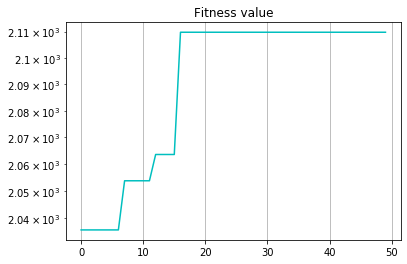

[[2035.6]
 [2035.6]
 [2035.6]
 [2035.6]
 [2035.6]
 [2035.6]
 [2035.6]
 [2053.8]
 [2053.8]
 [2053.8]
 [2053.8]
 [2053.8]
 [2063.6]
 [2063.6]
 [2063.6]
 [2063.6]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]
 [2109.8]]
you needs:
carbs: 258.97925. Accounts for 50.0%
protein: 103.5917. Accounts for 20.0%
lipid: 69.06113333333332. Accounts for 29.999999999999996%
total energy: 2071.834
hall of fame:
[[1, 4, 2, 2, 2, 1, 1, 1, 2, 1, 2], [1, 2, 2, 2, 2, 4, 1, 1, 2, 1, 2], [1, 4, 2, 1, 1, 1, 1, 2, 2, 1, 2], [1, 4, 2, 2, 1, 1, 1, 1, 2, 1, 2], [1, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2], [1, 3, 2, 2, 2, 3, 1, 1, 2, 1, 2], [1, 4, 2, 1, 2, 1, 1, 2, 2, 1, 1], [1, 4, 2, 2, 2, 1, 1, 1, 2, 1, 1], [1, 3, 2, 2, 2, 1, 1, 1, 2, 2, 2], [

In [10]:
pop, halloffame  = main()

print('you needs:')
energy = P*4 + L*9 + C*4
print("carbs: " + str(C) + ". Accounts for " + str(C*4*100/energy) + "%")
print("protein: " + str(P) + ". Accounts for " + str(P*4*100/energy) + "%")
print("lipid: " + str(L) + ". Accounts for " + str(L*9*100/energy) + "%")
print("total energy: " + str(C*4+L*9+P*4))

print('hall of fame:')
print(halloffame)
print()

# best = halloffame[0]

def cal(individual, selected_food):
    p = 0
    l = 0
    c = 0    
    for f in range(len(selected_food)):
        p = p + selected_food[f].protein * individual[f]
        l = l + selected_food[f].lipid * individual[f]
        c = c + selected_food[f].carb * individual[f]  
        energy = p*4 + l*9 + c*4
    print("protein: " + str(p) + ". Accounts for " + str(p*4*100/energy) + "%")
    print("lipd: " + str(l)    + ". Accounts for " + str(l*9*100/energy) + "%")
    print("carb.: " + str(c)   + ". Accounts for " + str(c*4*100/energy) + "%")
    print('total energy: ' + str(energy))
    p = p - P
    l = l - L
    c = c - C
#     print("protein: " + str(p))
#     print("lipd: " + str(l))
#     print("carb.: " + str(c))
for best in halloffame:  
#     print('best: ')
#     print(selected_food)
#     print(best)
    print(list(zip(selected_food, best)))
    cal(best, selected_food)
    print()

In [11]:
print(best)
eq1 = ''
eq2 = ''
eq3 = ''

for f in range(len(selected_food)):
    if f != len(selected_food)-1:
        eq1 = eq1 + str(selected_food[f].protein) + '*' + str(best[f]) + ' + '
        eq2 = eq2 + str(selected_food[f].lipid) + '*' + str(best[f]) + ' + '
        eq3 = eq3 + str(selected_food[f].carb) + '*' + str(best[f]) + ' + '
    else:
        eq1 = eq1 + str(selected_food[f].protein) + '*' + str(best[f]) + ' = ' + str(P)
        eq2 = eq2 + str(selected_food[f].lipid) + '*' + str(best[f]) + ' = ' + str(L)
        eq3 = eq3 + str(selected_food[f].carb) + '*' + str(best[f]) + ' = ' + str(C)
    print('food name: ' + selected_food[f].food_name)
#     print('protein:' + str(f.protein))
#     print('lipid: ' + str(f.lipid))
#     print('protein: ' + str(f.protein))


print(eq1)
print(eq2)
print(eq3)

eq1 = ''
eq2 = ''
eq3 = ''

for f in range(len(selected_food)):
    if f != len(selected_food)-1:
        eq1 = eq1 + str(selected_food[f].protein) + '*' + 'x' + str(f) + ' + '
        eq2 = eq2 + str(selected_food[f].lipid) + '*' + 'x' + str(f) + ' + '
        eq3 = eq3 + str(selected_food[f].carb) + '*' + 'x' + str(f) + ' + '
    else:
        eq1 = eq1 + str(selected_food[f].protein) + '*' + 'x' + str(f) + ' = ' + str(P)
        eq2 = eq2 + str(selected_food[f].lipid) + '*' + 'x' + str(f) + ' = ' + str(L)
        eq3 = eq3 + str(selected_food[f].carb) + '*' + 'x' + str(f) + ' = ' + str(C)
print()
print(eq1)
print(eq2)
print(eq3)

[1, 4, 2, 2, 1, 1, 1, 1, 1, 1, 2]
food name: white rice
food name: chicken
food name: banana
food name: white rice
food name: vegetables
food name: pork
food name: yogurt
food name: white rice
food name: vegetables
food name: pork
food name: yogurt
4.6*1 + 11.0*4 + 0.0*2 + 4.6*2 + 2.0*1 + 7.0*1 + 3.7*1 + 4.6*1 + 2.0*1 + 7.0*1 + 3.7*2 = 103.5917
0.6*1 + 12.3*4 + 0.0*2 + 0.6*2 + 0.0*1 + 8.0*1 + 3.0*1 + 0.6*1 + 0.0*1 + 8.0*1 + 3.0*2 = 69.06113333333332
44.2*1 + 4.6*4 + 15.0*2 + 44.2*2 + 5.0*1 + 0.0*1 + 4.8*1 + 44.2*1 + 5.0*1 + 0.0*1 + 4.8*2 = 258.97925

4.6*x0 + 11.0*x1 + 0.0*x2 + 4.6*x3 + 2.0*x4 + 7.0*x5 + 3.7*x6 + 4.6*x7 + 2.0*x8 + 7.0*x9 + 3.7*x10 = 103.5917
0.6*x0 + 12.3*x1 + 0.0*x2 + 0.6*x3 + 0.0*x4 + 8.0*x5 + 3.0*x6 + 0.6*x7 + 0.0*x8 + 8.0*x9 + 3.0*x10 = 69.06113333333332
44.2*x0 + 4.6*x1 + 15.0*x2 + 44.2*x3 + 5.0*x4 + 0.0*x5 + 4.8*x6 + 44.2*x7 + 5.0*x8 + 0.0*x9 + 4.8*x10 = 258.97925
